In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
from fpl import (
    Loader,
    Player,
    find_matching_players,
    compute_points_per_game,
    compute_form,
)

## Expected Points Model

We make a very crude and simple model for expected points. Using the framework of [General Model Theory](https://en.wikipedia.org/wiki/Model):

##### Mapping - what phenomena are we trying to model?
Given that a player plays a particular fixture (greater than zero minutes played), we want to model how many points the player will score.

##### Reduction - what simplifying assumptions will we make?
The simplifying assumptions we will make are as follows:
- Points scored depends on only form, points per game and fixture difficulty (again, only games where a player plays more than zero minutes)
- Linear regression assumptions (linearity, independence of errors, homoskedasticity, normality)
- There will be no attempt to estimate minutes of each player or likelihood of playing; the effect of minutes will come indirectly through points per game
- There will be no attempt to use other useful statistics from other data sources such as betting odds, opta data, xG etc
- We will restrict our data for analysis to gameweeks 20-24 so that averages are not calculated over so few gameweeks

##### Pragmatism - when can we use the model from a practical point of view?
We can use this model if, for each fixture each player plays, we can calculate:
1. Their points per game so far that season, prior to the fixture.
2. Their form so far than season prior to the fixture.
3. An indication of the difficulty of a particular fixture.

This should be relatively simple, therefore we can create an `ExpectedPointsCalculator` from such a model and plug it into our `Optimizer`.

In [2]:
records = []
for player_id in range(1, len(Loader.get_static_info()["elements"])):
    player_info = Loader.get_player_basic_info(player_id)
    for gameweek in [20, 21, 22, 23, 24]:
        points_per_game = compute_points_per_game(player_id, gameweek)
        form = compute_form(player_id, gameweek)
        gameweek_info = Loader.get_player_historical_info_for_gameweek(
            player_id, gameweek
        )
        # A player can play multiple fixtures in a single gameweek i.e. a "double" gameweek
        for fixture_info in gameweek_info:
            team_id = player_info["team"]
            team_info = Loader.get_team_basic_info(team_id)
            opponent_team_id = fixture_info["opponent_team"]
            opponent_team_info = Loader.get_team_basic_info(opponent_team_id)
            fixture_difficulty = (
                opponent_team_info["strength_overall_away"]
                if fixture_info["was_home"]
                else opponent_team_info["strength_overall_home"]
            )
            if fixture_info["minutes"] == 0:
                continue
            else:
                records.append(
                    {
                        "player_id": player_id,
                        "gameweek": gameweek,
                        "fixture": fixture_info["fixture"],
                        "web_name": player_info["web_name"],
                        "team": team_info["short_name"],
                        "opponent_team": opponent_team_info["short_name"],
                        "total_points": fixture_info["total_points"],  # response
                        "form": form,  # predictor
                        "points_per_game": points_per_game,  # predictor
                        "fixture_difficulty": fixture_difficulty,
                    }
                )

df = pd.DataFrame(records)

In [3]:
df[df["player_id"] == 328]

,player_id,gameweek,fixture,web_name,team,opponent_team,total_points,form,points_per_game,fixture_difficulty
760,328,20,196,M.Salah,LIV,MUN,7,12.8,11.2,1140
761,328,21,206,M.Salah,LIV,NFO,2,13.2,11.0,1195
762,328,22,212,M.Salah,LIV,BRE,3,11.0,10.6,1100
763,328,23,226,M.Salah,LIV,IPS,8,7.4,10.2,1075
764,328,24,232,M.Salah,LIV,BOU,16,5.0,10.1,1195
765,328,24,144,M.Salah,LIV,EVE,13,5.0,10.1,1095


#### In sample

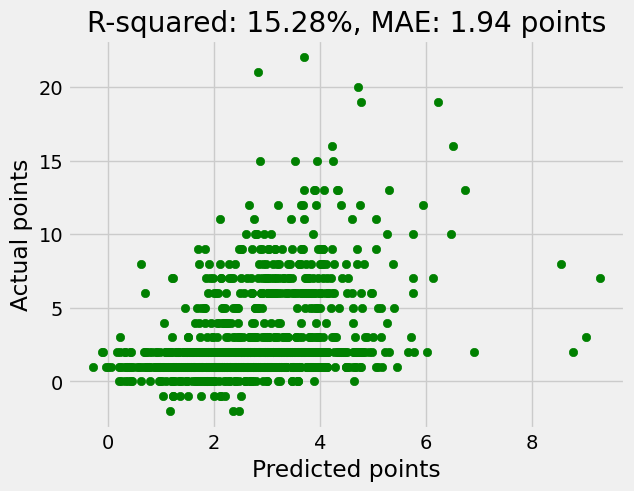

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_points   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     71.24
Date:                Mon, 24 Feb 2025   Prob (F-statistic):           2.32e-42
Time:                        18:10:03   Log-Likelihood:                -2894.7
No. Observations:                1189   AIC:                             5797.
Df Residuals:                    1185   BIC:                             5818.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.9007      1.231      8.044      0.000       7.486      12.315
form                   0.1153      0.065      1.762      0.078      -0.013       0.244
points_per_game        0.6032      0.092      6.557      0.000       0.423       0.784
fixture_difficulty    -0.0078      0.001     -7.442      0.000      -0.010      -0.006
==============================================================================
Omnibus:                      520.357   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2715.067
Skew:                           2.002   Prob(JB):                         0.00
Kurtosis:                       9.226   Cond. No.                     1.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
df_train = df[df["gameweek"] < 24].copy()
model = smf.ols(
    formula="total_points ~ form + points_per_game + fixture_difficulty", data=df_train
)
fitted = model.fit()
df_train["prediction"] = fitted.predict(df_train)
df_train["residual"] = df_train["prediction"] - df_train["total_points"]
mae_in_sample = np.mean(np.abs(df_train["residual"]))
r2_in_sample = 1 - (
    np.sum(df_train["residual"] ** 2)
    / np.sum((df_train["total_points"] - np.mean(df_train["total_points"])) ** 2)
)
plt.scatter(df_train["prediction"], df_train["total_points"], color="green")
plt.xlabel("Predicted points")
plt.ylabel("Actual points")
plt.title(
    f"R-squared: {round(100*r2_in_sample, 2)}%, MAE: {round(mae_in_sample, 2)} points"
)
# plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()
fitted.summary()

#### Out of sample

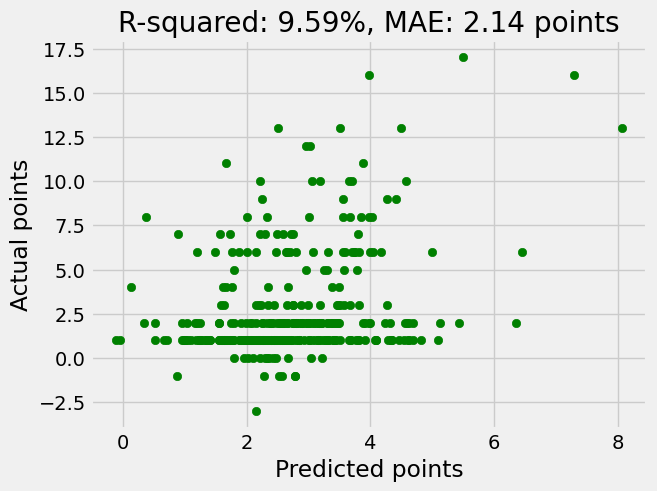

In [5]:
df_test = df[df["gameweek"] == 24].copy()
df_test["prediction"] = fitted.predict(df_test)
df_test["residual"] = df_test["prediction"] - df_test["total_points"]
mae_out_of_sample = np.mean(np.abs(df_test["residual"]))
r2_out_of_sample = 1 - (
    np.sum(df_test["residual"] ** 2)
    / np.sum((df_test["total_points"] - np.mean(df_test["total_points"])) ** 2)
)
plt.scatter(df_test["prediction"], df_test["total_points"], color="green")
plt.xlabel("Predicted points")
plt.ylabel("Actual points")
plt.title(
    f"R-squared: {round(100*r2_out_of_sample, 2)}%, MAE: {round(mae_out_of_sample, 2)} points"
)
plt.show()

## Discussion and improvements

Conditional on the dataset and our intention, the linear model is adequate. There are roughly $1000$ samples with a relatively low signal-noise ratio, therefore a high-bias and low-variance model is appropriate. Perhaps the most important thing is that the model is perfect for demonstration purposes; it is simple, explainable and can be made easily into an `ExpectedPointsCalculator`.

### Dataset

Whilst the out-of-sample R-squared of $10\%$ is nothing to scream about, at least it gives us a systematic way of predicting the points a player will score. The model would almost certainly be improved by enriching the dataset - this is the 'lowest hanging fruit':
- We could increase the number of samples $n$ by simply using a longer history of gameweeks and potentially previous seasons (though this would require extra assumptions since points rules are season dependent)
- We could increase the number of predictors $p$ by using variables from the FPL website such as `minutes`, `xG`, `position`
- We could increase the number of predictors $p$ by using variables from external data sources such as betting odds and opta data

Using more data and features would probably justify high-variance low-bias models.

### Linear regression

In terms of our linear regression assumptions:
- **Linearity**: From the residual plot below, the linearity assumption roughly holds.
- **Independence of errors**: Within a single gameweek, errors are not completely independent, but their dependence is somewhat limited; if a defender in a team outperforms his expected points, it's very likely a different defender in the same team outperforms his expected points, and a striker in the opposing team underperforms his expected points. In order to address this, we could model the interaction of players through a correlation matrix with some kind of factor model - though this is out of the scope of this project. In terms of correlation between errors over time, it is difficult to tell, as we only have four weeks of data. If we had more data, we would probably see something in the ACF or PACF plot for an individual player, given that commentators say form influences performance. However, since we already use `form` as a predictor variable, maybe a time-series model is a bit overkill. 
- **Homoskedasticity**: From the residual plot below, this assumption is somewhat violated; it would be beneficial to use transform the response variable, use polynomial features or use a similar model such as quantile regression.
- **Normality**: From the residual histogram below, this assumption is violated; it would be beneficial to use transform the response variable, use polynomial features or use a similar model such as quantile regression. There is probably another predictor that would help describe the output better.

Other considerations:
- **Collinearity**:
- **Outliers**:

### Pipeline

Improvements:
- As it stands, this is an ad-hoc, offline calibration of an expected points model. In the future, it would be better to have a 'rolling' regression which is run in a more automatic way.
- `statsmodels` was chosen for its ease of use and quick exploratory capabilities. `scikit-learn` would be more appropriate in the future, with the added complexity of more features, different models, saving parameters, normalization etc.

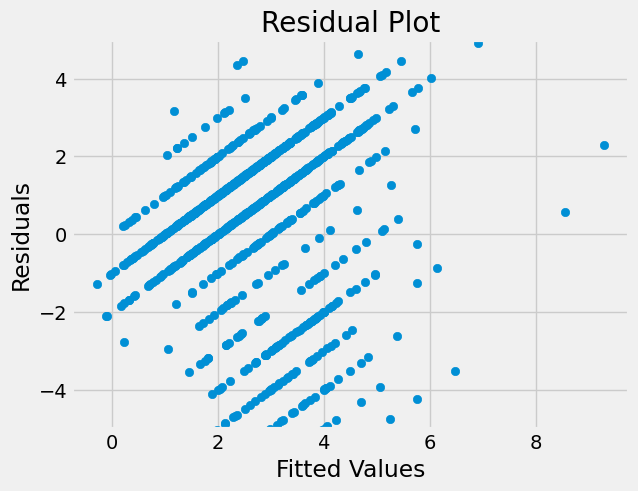

In [6]:
plt.scatter(df_train["prediction"], df_train["residual"])
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.ylim(-5, 5)
plt.title("Residual Plot")
plt.show()

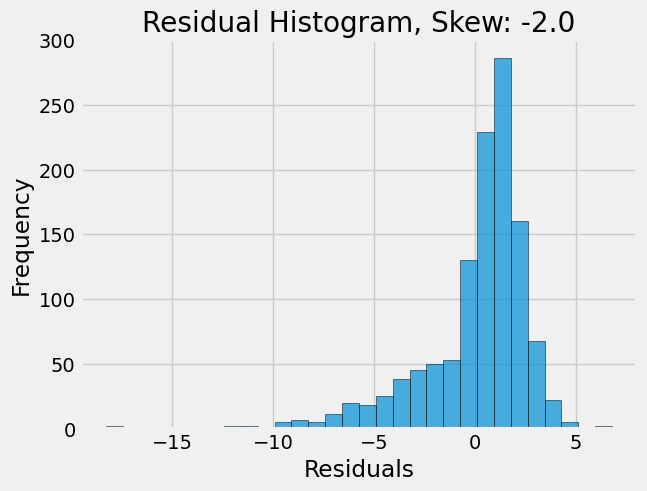

In [7]:
skew_residuals = pd.Series(df_train["residual"]).skew()
plt.hist(df_train["residual"], bins=30, edgecolor="k", alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title(f"Residual Histogram, Skew: {round(skew_residuals, 2)}")
plt.show()

,form,points_per_game
form,1.000000,0.756479
points_per_game,0.756479,1.000000


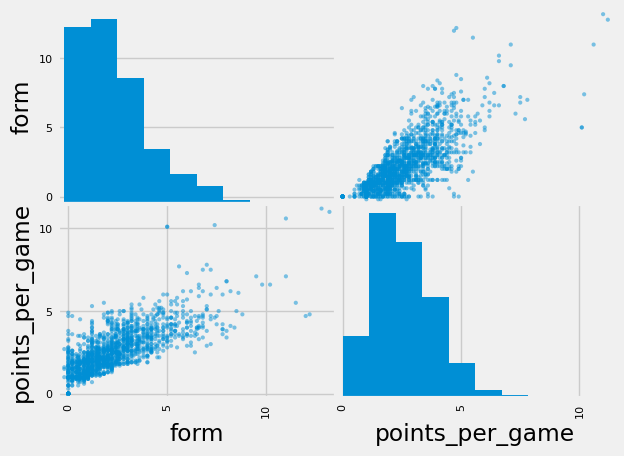

In [8]:
pd.plotting.scatter_matrix(df[["form", "points_per_game"]])
df[["form", "points_per_game"]].corr()

,dfb_Intercept,dfb_form,dfb_points_per_game,dfb_fixture_difficulty,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
818,0.207607,0.552756,-0.342431,-0.203274,0.092001,5.179722,0.013531,0.606634,5.237163,0.613361
761,0.082556,-0.105242,-0.209927,-0.033384,0.055745,-2.495602,0.034565,-0.472208,-2.501130,-0.473254
227,0.151813,0.072822,0.170366,-0.188204,0.045594,4.634613,0.008419,0.427056,4.675223,0.430798
954,0.073365,0.263759,-0.014442,-0.098667,0.043216,3.455082,0.014274,0.415767,3.471153,0.417701
762,-0.002124,-0.003376,-0.241114,0.046216,0.037923,-2.211702,0.030078,-0.389475,-2.215346,-0.390116
...,...,...,...,...,...,...,...,...,...,...
282,-0.042905,-0.007721,-0.054584,0.052262,0.003520,-1.612405,0.005386,-0.118654,-1.613496,-0.118734
929,-0.036003,0.081824,-0.037001,0.037453,0.003446,2.115731,0.003069,0.117398,2.118844,0.117571
829,-0.018775,0.012502,-0.076122,0.029943,0.003403,-1.368268,0.007217,-0.116663,-1.368773,-0.116706
183,-0.042197,0.062359,-0.003166,0.039147,0.003402,1.930540,0.003638,0.116658,1.932767,0.116793


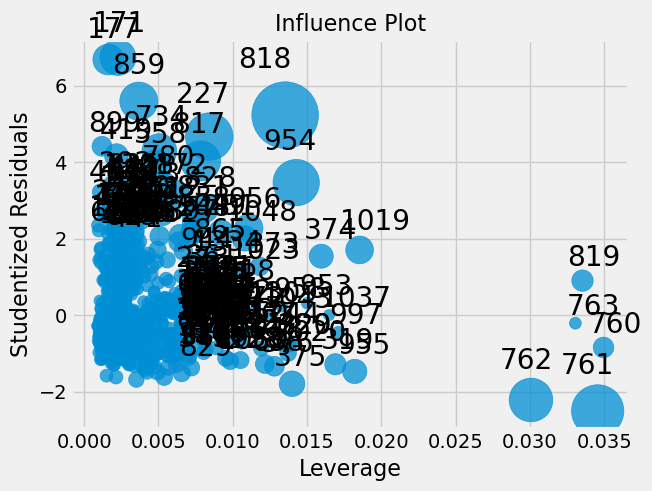

In [10]:
sm.graphics.influence_plot(fitted)
df_influence = fitted.get_influence().summary_frame()
df_influence[df_influence["cooks_d"] > 4 / fitted.nobs].sort_values(
    "cooks_d", ascending=False
)